In [1]:
from PIL import Image, ImageDraw
import math
import matplotlib.pyplot as plt
from scipy import misc

def display_image(filename, width=8):
    plt.clf()
    disp_image = misc.imread(filename)
    plt.imshow(disp_image)
    plt.axis("off")
    plt.rcParams["figure.figsize"] = [width,width]
    plt.show()

# Image-Elipsify

Iterates over each pixel in an image and determines the largest possible circle that can be placed on the image without overwriting any signifigant features in the image. 

First, we need a way to load an image into python. We can do this with the PIL library, which can load an image into a two dimensional array of tuples, with each tuple representing the RGB value for each pixel. 

The program works best with images that contain large regions of roughly the same color. For this example, we will use the following image:

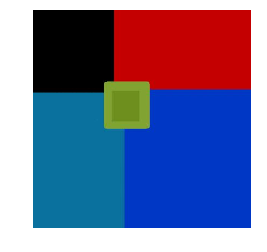

In [2]:
display_image("TestImage.jpg")

First, we need to load the image into Python, determine its dimensions, and set a few parameters. 

We will set the color threshold to 7, meaning that if any RGB element of pixel is within 7 points of another pixel, they will be treated as the same color.

The step determines how many pixels to skip over when iterating over the image. While ideally it would be best to check every pixel, we can save on computation time by allowing some pixels to be skipped. 

In [3]:
input_filename = "TestImage.jpg"
threshold = 7
step = 5

img = Image.open(input_filename)
pixels = img.load()
width, height = img.size

Next, we need a way to generate a list of points on the perimiter of a circle from a given radius. This way, we can compare the color at each point to the color at the center of the circle, and if every pixel is within the threshold, we can determine that the circle does pass through any major features. We can do this with two functions, one to generate the relative points around a radius and another to calculate their absolute position on the image.

In [4]:
def get_relative_points(radius):
    # Number of points to calculate within one quadrant
    radius = radius + 1
    quadrant = []
    angle = math.pi / (2 * radius)

    # Calculate relative locations of each point within the quadrant
    for x in range(1, radius + 1):
        xcoord = int(round(radius * math.cos(x * angle)))
        ycoord = int(round(radius * math.sin(x * angle)))
        quadrant.append((xcoord, ycoord))

    # Calculate each relative point within the edge of the circle
    points = []
    for point in quadrant:
        points.append((point[0], point[1]))
        points.append((point[0], (point[1] * -1)))
        points.append(((point[0] * -1), point[1]))
        points.append(((point[0] * -1), (point[1] * -1)))

    return points


def get_points(x, y, radius):
    relative_points = get_relative_points(radius)
    absolute_points = []

    for relative_point in relative_points:
        absolute_points.append((x + relative_point[0], y + relative_point[1]))

    return absolute_points

Since we need to frequently determine whether or not to pixels are the same color, we can wrap this up into a function as well:

In [5]:
def closeness(color_a, color_b):
    if color_a is None or color_b is None:
        return 255

    a = abs(color_a[0] - color_b[0])
    b = abs(color_a[1] - color_b[1])
    c = abs(color_a[2] - color_b[2])
    mean = (a + b + c) / 3

    return int(mean)

We will also need to make sure that we are only checking pixels that are within the bounds of the image. Specifically, that the radius of a new circle will stay within the bounds of the image, and that each pixel is within the bounds of the image:

In [6]:
def on_image(x, y, width, height):
    if x < 0 or y < 0:
        return False
    if x > width - 1 or y > height - 1:
        return False
    return True


def radius_off_image(x, y, radius, width, height):
    if (x - radius) < 0 or (y - radius) < 0:
        return True
    if (x + radius) > width or (y + radius) > height:
        return True
    return False

## Testing an individual circle

Now that we have a few basic functions for checking the image, we can create a function for testing whether or not a circle intercepts any features on the image. We will create a test_radius function that returns True if a circle of a specific radius centered at a specific x-y coordinate is valid.

In [7]:
# Tests if a circle of a given radius is within the color threshold
def test_radius(x, y, radius, pixels, width, height, threshold):
    # Make sure that all the bounds of the circle are within the image
    if radius_off_image(x, y, radius, width, height):
        return False

    # Calculate each point on the perimeter of the circle
    absolute_points = get_points(x, y, radius)

    # Determine the color at the center of the circle
    center_color = pixels[x, y]

    for point in absolute_points:
        if not on_image(point[0], point[1], width, height):
            return False
        point_color = pixels[point[0], point[1]]
        if closeness(center_color, point_color) > threshold:
            return False
    return True

As an example, we can try to test a few circles around the image and check if they are valid.

The circle of radius 10 centered at (50, 300) should be valid and return True, as it is located roughly within the center of the lower-left part of the image with no features in the way.

The circle of radius 100 centered at the same location should return False, as the bounds of the circle will be outside the bounds of the image. 

Likewise, the circle of radius 100 centered at (150, 250) should also return False, as it crosses between the light and dark blue regions of the image.

In [8]:
print(test_radius(50, 300, 10, pixels, width, height, threshold))
print(test_radius(50, 300, 100, pixels, width, height, threshold))
print(test_radius(150, 250, 100, pixels, width, height, threshold))

True
False
False


Next, we need to find the largest circle that can be drawn centered at a given point. We can do this by continously increasing the radius of the circle we are checking until we find one that fails the test_radius method.

In [9]:
def find_biggest_radius(x, y, pixels, width, height, threshold, step, current_radius):
    radius = current_radius
    while test_radius(x, y, radius, pixels, width, height, threshold):
        radius = radius + step
    return radius

If we call the find_biggest_radius function at the center of the black box in the upper-left corner of the image, it will return the radius of a circle that roughly fills the entire black box. Here we will use the location (60, 60) and a step size of 5, meaning at each step increase the radius by 5 rather than checking every possible radius, to save compuation time. 

In [10]:
print(find_biggest_radius(60, 60, pixels, width, height, threshold, 5, 5))

60


Now all we need to do is iterate over each pixel in the image, call find_biggest_radius on each pixel, and determine the location of the largest circle that can be drawn on the image. As with the find_biggest_radius function, we will include a step size, so that can save computation time by skipping some pixels in the image. 

In [11]:
def find_biggest_circle(pixels, width, height, threshold, step=5):
    largest_circle = (0, 0, 0)
    current_radius = 4
    for x in range(0, width, 5):
        print("\rProgress {:2.1%}".format(x / width), end="")
        for y in range(0, height, step):
            current_radius = find_biggest_radius(x, y, pixels, width, height, threshold, step, current_radius)
            if current_radius > largest_circle[2]:
                largest_circle = (x, y, current_radius)
    print("\rProgress {:2.1%}".format(width / width))
    return largest_circle

In [12]:
biggest_circle = find_biggest_circle(pixels, width, height, threshold, 5)
print(biggest_circle)

Progress 100.0%
(285, 295, 104)


Now that we know the coordinates and size of the largest possible circle, we can draw the circle on the image by using the PIL ImageDraw library. We'll also use the function we defined at the start of this notebook to display images using matplotlib.

In [13]:
def draw_circle(image, circle, fill_color):
    draw = ImageDraw.Draw(image)
    bounding_box = (circle[0] - circle[2], circle[1] - circle[2], circle[0] + circle[2], circle[1] + circle[2])
    draw.ellipse(bounding_box, fill=fill_color)
    return image

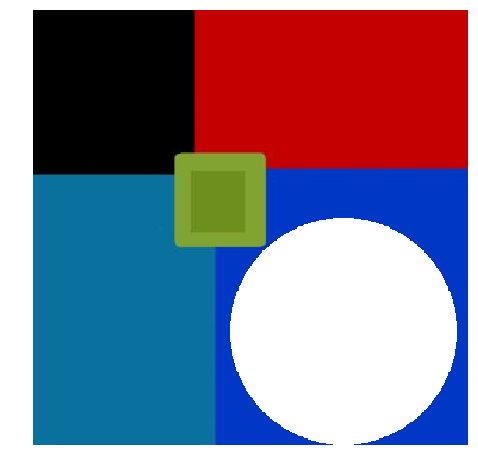

In [14]:
new_image = draw_circle(img, biggest_circle, (255, 255, 255))
new_image.save("NewImage.png")
display_image("NewImage.png")

Lets try it on another image, this time wrapping it into a single function to open, parse, and save the modified image.

In [15]:
def parse_image(old_filename, new_filename):
    img = Image.open(old_filename)
    pixels = img.load()
    width, height = img.size
    
    biggest_circle = find_biggest_circle(pixels, width, height, 7, 5)
    new_image = draw_circle(img, biggest_circle, (255, 255, 255))
    new_image.save(new_filename)
    
def display_parsed_image(filename):
    display_image(filename)
    parse_image(filename, "New" + filename)
    display_image("New" + filename)

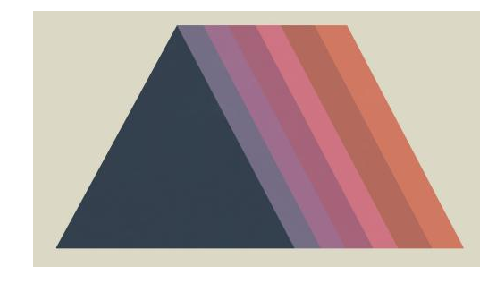

Progress 100.0%


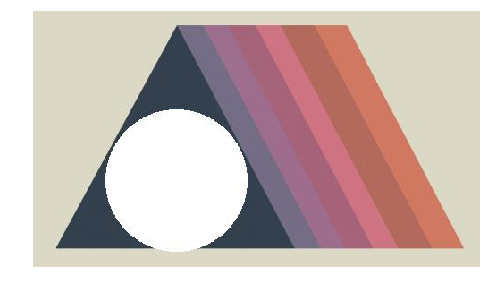

In [16]:
display_parsed_image("TestImage2.jpg")

By running many iterations of the program over an image, we can create an "ellipsified" version, where the image is drawn using only colored circles. A few examples are given below:

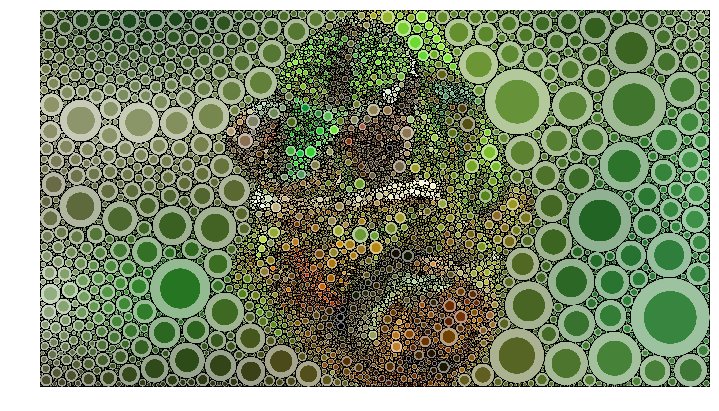

In [19]:
display_image("chameleon.png", 12)

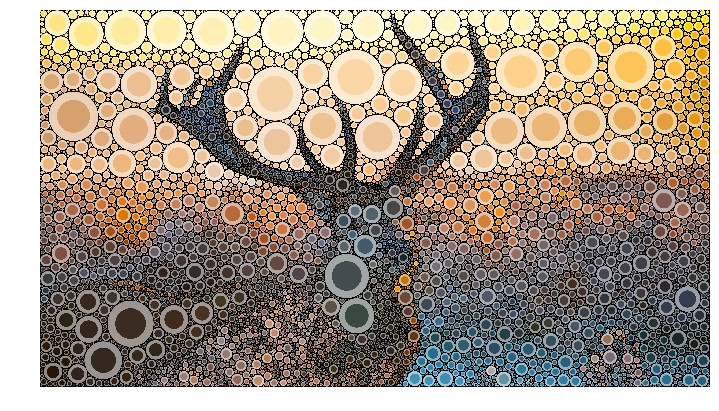

In [18]:
display_image("elk.png", 12)